In [1]:
import uproot
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd

In [31]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict_ak1["hit_detID"],
                                      "edep":    dq_dict_ak1["hit_edep"],
                                      "elmID":   dq_dict_ak1["hit_elmID"],
                                      "truthx":  dq_dict_ak1["hit_truthx"],
                                      "truthy":  dq_dict_ak1["hit_truthy"],
                                      "truthz":  dq_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge": dq_dict_ak1["ge"],
                                        }),
                        "Showers":ak.zip({
                                        "nshowers": dq_dict_ak1["n_showers"],
                                        "sedep_ecal": dq_dict_ak1["sedep_ecal"],
                        })
                       }, depth_limit=1)
    return dq_events

In [49]:
def printAcceptance(ifile):
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events["Hits"]
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
    ecal_mask = ak.any(dq_hits.detID == 100, axis=1)
    shower_mask = ak.any(dq_showers.nshowers == 2,axis=1) & ak.any(dq_showers.sedep_ecal>0,axis=1)
    
    shower_index = np.where(shower_mask)
    ecal_index = np.where(ecal_mask)
    ecalshower_index = np.where(ecal_mask & shower_mask)
    
    dq_showers = dq_showers[ecal_mask & shower_mask]
    dq_electrons = dq_electrons[ecal_mask & shower_mask]
    shower_mask_energy = ak.all(dq_showers.sedep_ecal > 0.05*dq_electrons.ge,axis=1)
    total_index = np.where(shower_mask_energy)

    #print('shower index',shower_index)
    #print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    #print('Fraction of events with showers and energy deposits: ',len(shower_index[0])/len(dq_events))
    #print('Fraction of events with showers and energy deposits and hits in EMCAL: ',len(ecalshower_index[0])/len(dq_events))
    #print('Fraction of events with showers and energy deposits and hits in EMCAL and at least 5%% edep: ',len(total_index[0])/len(dq_events))
    acc = len(total_index[0])/len(dq_events)
    return acc

In [54]:
def plotAcceptance(masses,acc,mech,tag=''):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    masses = [float(i) for i in masses]
    naps = acc
    plt.plot(masses,naps,color='green')
    ax.set_xlabel("A' mass (GeV)")
    ax.set_ylabel(r"Fraction of evts w energy shower (5%% energy deposit)")
    ax.set_xlim(.01,2.3) 
    ax.set_ylim(0.001,1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(r'$E_{beam}=$120 GeV,POT=1.44e18,$\epsilon=10^{-6}$ %s'%(mech))
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    plt.show()
    plt.savefig('acceptance_%s%s.png'%(mech,tag))

In [50]:
masses = {}
masses['Brem'] = ["0.011603","0.015117","0.025659","0.033428","0.043551","0.056739","0.073920","0.096304","0.125467",
                  "0.163460","0.212958","0.361459","0.470915","0.613515","0.799296","1.041330","1.356670","1.767490",
                  "2.302710"]
masses['Eta'] = ["0.010502","0.012922","0.015900","0.019564","0.024072","0.029619","0.036445","0.044843","0.055176",
                 "0.067891","0.083535","0.102784","0.126469","0.155612","0.191470","0.235592","0.289880","0.356678",
                 "0.438869","0.540000"]
acceptances = {}
for proc in ["Brem","Eta"]:
    acceptances[proc] = []
    for mass in masses[proc]:
        ifile = "data/simeval_electrons_emcal_-6/sim_eval_%s_%s_z500_600_eps_-6.root"%(proc,mass)
        acceptances[proc].append(printAcceptance(ifile))

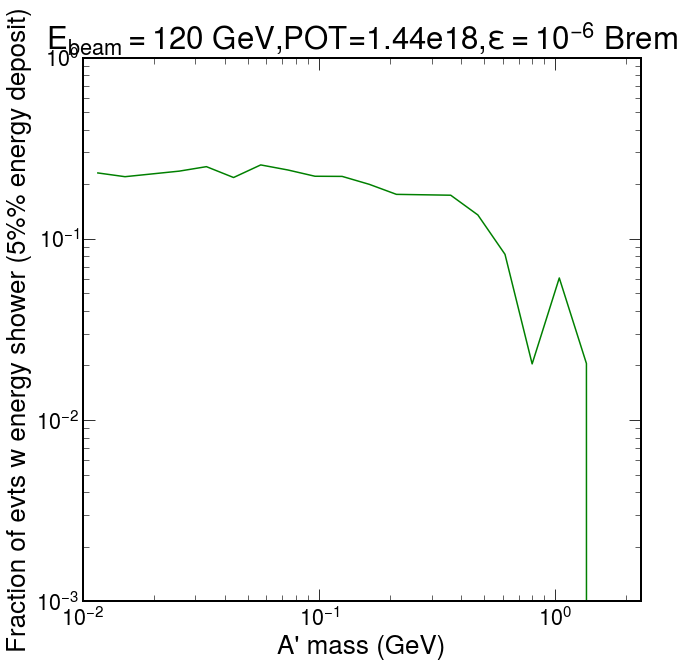

<Figure size 720x720 with 0 Axes>

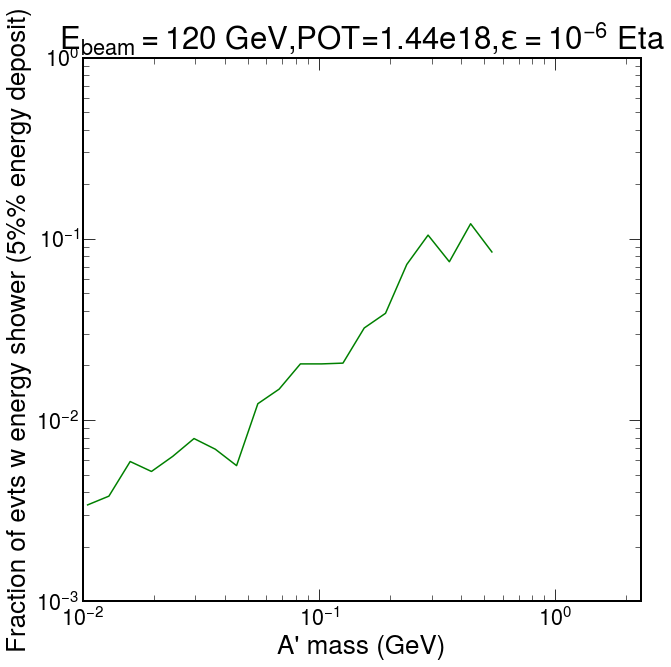

<Figure size 720x720 with 0 Axes>

In [55]:
for proc,acc in acceptances.items():
    #print(proc,acc)
    plotAcceptance(masses[proc],acc,proc,'showeredepmask')
    #plotAcceptance(masses[proc],acc,proc,'showermask')
    #plotAcceptance(masses[proc],acc,proc,'hitmask')